In [23]:
import networkx as nx
import custom_funcs as cf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
seaborn.set_context('paper')
seaborn.set_style('white')


from tqdm import tqdm

from numba import jit, autojit
from time import time
from collections import defaultdict, Counter
from joblib import Parallel, delayed
from Bio import SeqIO
from Levenshtein import distance
from random import shuffle
from scipy.stats import percentileofscore

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Read in the graph data and clean it.
G = nx.read_gpickle('20150902_all_ird Final Graph.pkl')
G = cf.clean_host_species_names(G)
G = cf.impute_reassortant_status(G)
G = cf.impute_weights(G)
G = cf.remove_zero_weighted_edges(G)

In [25]:
all_hosts = set([d['host_species'] for n, d in G.nodes(data=True)])
len(all_hosts)

152

In [26]:
len(G.edges())

25683

In [27]:
cf.count_edges(G, attr='host_species')

{'full_complement': {'diff_attr': 3114.633333333333,
  'same_attr': 13106.366666666665},
 'reassortant': {'diff_attr': 1456.040476190476,
  'same_attr': 735.9595238095237}}

# Compute propotion of edges reassortant same vs. different

In [28]:
# Proportion reassortant in data
data_props = cf.edge_proportion_reassortant(G, attr='host_species')
data_props

{'diff_attr': 0.31856144998939934, 'same_attr': 0.05316732994746788}

In [29]:
## Note: I know that this is bad practice, to have mixed variable scopes. Bear with me for a while...
excluded_hosts = ['Aquatic Bird', 'Avian', 'Bird', 'Duck', 'Environment', 'Mallard-Black Duck Hybrid', 'Sea Mammal', 
                  'Unknown', 'Waterfowl']

def null_distribution_proportion_reassortant(G, equally=False):
    G_shuffled = cf.shuffle_node_attribute_label(G, 'host_species', equally)
    props = cf.edge_proportion_reassortant(G_shuffled, 'host_species', exclusions=excluded_hosts)
    return props

In [30]:
# Proportion reassortant under null
start = time()
props_null = Parallel(n_jobs=-1)(delayed(null_distribution_proportion_reassortant)(G, equally=True) for i in range(100))
end = time()
print(end - start)

288.4284179210663


In [31]:
null = pd.DataFrame(props_null)
null.mean()

diff_attr    0.124810
same_attr    0.122291
dtype: float64

In [32]:
null.quantile(0.995)

diff_attr    0.127529
same_attr    0.170617
dtype: float64

In [33]:
data_samediff = pd.DataFrame([data_props])
data_samediff.mean()

diff_attr    0.318561
same_attr    0.053167
dtype: float64

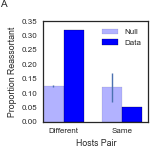

In [34]:
seaborn.set_context("paper")
seaborn.set_style('white')

fig1 = plt.figure(figsize=(2,2))
ax1 = fig1.add_subplot(1,1,1)
ind = np.arange(2)
width = 0.35

ax1.bar(ind, null.mean(), width, 
        color='blue', label='Null', alpha=0.3, 
        yerr=[null.mean() - null.quantile(0.005),
              null.quantile(0.995) - null.mean(),])
        # yerr=null.std()*3)
ax1.bar(ind+width, data_samediff.mean(), width, color='blue', label='Data')
ax1.set_xticks(ind+width)
ax1.set_xticklabels(['Different', 'Same'])
ax1.set_xlabel('Hosts Pair')
ax1.set_ylabel('Proportion Reassortant')
ax1.legend()
ax1.annotate('A', ha='left', va='top', xy=(0,1), xycoords='figure fraction')
plt.subplots_adjust(left=0.25, bottom=0.2, right=0.98)
plt.savefig('figures/Proportion Reassortant.pdf')

In [35]:
# Compute exact stats
percentileofscore(a=null['same_attr'], score=data_samediff['same_attr'].values)

0.0

In [36]:
null['same_attr'].mean() - data_samediff['same_attr']

0    0.069124
Name: same_attr, dtype: float64

In [37]:
null['diff_attr'].mean() - data_samediff['diff_attr']

0   -0.193752
Name: diff_attr, dtype: float64

# Compute proportion of reassortant by host class

Host classes:

- Wild bird
- Wild mammal
- Domestic bird
- Domestic mammal
- Human

In [38]:
# Open the bird vs. mammal CSV file

host_classes = pd.read_csv('supp_data/host_groups.csv').drop_duplicates()
# I suspected there may have been duplicates, so I added the drop_duplicates() function call.
host_classes.set_index(['Country', 'Species'], inplace=True)
host_classes.ix['Canada'].ix['American Black Duck']

Habitat/setting        Wild
Bird, Mammal, Human    Bird
Name: American Black Duck, dtype: object

In [39]:
# Impute each node with the appropriate metadata. We will create a new node field: "host_class".
# The try/except coding pattern allows me to iteratively identify things for which we have no labels yet.

for n, d in G.nodes(data=True):
    c = d['country']
    s = d['host_species']
    try:
        hc = host_classes.ix[c].ix[s]
        habt = hc['Habitat/setting']
        host = hc['Bird, Mammal, Human']

        host_class = habt + ' ' + host
        G.node[n]['host_class'] = host_class
    except:
        print(c,s)

In the revisions to the paper, Reviewer \#2 requested that we use accurate host group metadata rather than the heuristic we used in the cell above. As such, we have incorporated new surveillance data from the influenza research database that explicitly overwrites the `host_class` from the cell above with the correct metadata.

In [40]:
#### THIS IS WHERE THE CODE SHOULD GO ####
# Read in the bird surveillance data
birds = pd.read_csv('supp_data/20160210_avian_surveillance.tsv', sep='\t')
birds = birds[['Strain Name', 'Bird Behavior']]
birds['Strain Name'] = birds['Strain Name'].str.split('(').str[0]
birds.columns = ['Strain Name', 'Behavior']

# Read in the mammal surveillance data
mammals = pd.read_csv('supp_data/20160210_mammal_surveillance.tsv', sep='\t')
mammals = mammals[['Strain Name', 'Behavior']]
mammals['Strain Name'] = mammals['Strain Name'].str.split('(').str[0]

# Join the two data tables together
behavior = birds.append(mammals)
behavior.reset_index(drop=True, inplace=True)
behavior = behavior.drop_duplicates()
behavior.head()  # only show the last 5 entries

,Strain Name,Behavior
0,A/quail/Lebanon/273/2010,Domestic
1,A/quail/Lebanon/272/2010,Domestic
2,A/chicken/Romania/543-2/2010,Domestic
3,A/duck/Thailand/CU-LM7291T/2010,Domestic
4,A/duck/Thailand/CU-LM7294T/2010,Domestic


In [41]:
# Count the number of nodes that will be re-checked.
strains = list(behavior['Strain Name'])
counter = 0
for n, d in G.nodes(data=True):
    if n in strains:
        counter += 1
        
        
print("There are {0} strains that will be re-checked".format(counter))

There are 2983 strains that will be re-checked


In [42]:
# Do the actual changing of host class
num_checked = 0
num_changed = 0
for r, d in behavior.iterrows():
    strain_name = d['Strain Name']
    behavior = d['Behavior']

    if strain_name in G.nodes():
        host_class = G.node[strain_name]['host_class']
        animal_behavior = host_class.split(' ')[0]  # i.e. the "Domestic" in "Domestic Bird"
        animal_type = host_class.split(' ')[1]  # i.e. the "Bird" in "Domestic Bird"
        num_checked += 1
        if behavior != animal_behavior:  # this is where we do the overwrite.
            host_class = behavior + ' ' + animal_type
            G.node[strain_name]['host_class'] = host_class

            num_changed += 1
    
print('Number checked: {0}'.format(num_checked))
print('Number changed: {0}'.format(num_changed))

Number checked: 2983
Number changed: 23


In [43]:
data_props = cf.edge_proportion_reassortant(G, attr='host_class')
data_props

{'diff_attr': 0.30981404958677683, 'same_attr': 0.10072620488501755}

In [44]:
# A function that computes the proportion reassortant across different node attributes.

def counts_reassortant_domain_graph(G, node_attr):
    """
    Computes the weighted counts of reassortant edges when going between different node attributes.
    
    Returns a "domain graph" with counts of weighted reasosrtant edges and sum weighted edges.
    """
    hg_graph = nx.DiGraph()

    for n, node_d in G.nodes(data=True):

        in_edges = G.in_edges(n, data=True)
        total_edges = len(in_edges)
        is_reassortant = node_d['reassortant']

        sk_hg = G.node[n][node_attr]
        if sk_hg not in hg_graph.nodes():
            hg_graph.add_node(sk_hg)

        for sc, _, edge_d in in_edges:
            sc_hg = G.node[sc][node_attr]
            if sc_hg not in hg_graph.nodes():
                hg_graph.add_node(sc_hg)

            if (sc_hg, sk_hg) not in hg_graph.edges():
                hg_graph.add_edge(sc_hg, sk_hg, total=edge_d['weight'], reassortant=0)
            if (sc_hg, sk_hg) in hg_graph.edges():
                hg_graph.edge[sc_hg][sk_hg]['total'] += edge_d['weight']

            if is_reassortant:
                hg_graph.edge[sc_hg][sk_hg]['reassortant'] += edge_d['weight']

    for sc, sk, d in hg_graph.edges(data=True):
        hg_graph.edge[sc][sk]['p_reassortant'] = d['reassortant'] / d['total']
        
    return hg_graph


In [45]:
# Compute the proportion reassortant across different host class pairs.
hg = counts_reassortant_domain_graph(G, 'host_class')
# We will ignore edges that involve "unknown" hosts.
for n in hg.nodes():
    if 'Unknown' in n:
        hg.remove_node(n)
# hg.edges(data=True)
hg.edges(data=True)

[('Wild Bird',
  'Wild Bird',
  {'p_reassortant': 0.30572414613828447,
   'reassortant': 1284.5000000000002,
   'total': 4201.499999999994}),
 ('Wild Bird',
  'Wild Mammal',
  {'p_reassortant': 0.5, 'reassortant': 1.5, 'total': 3.0}),
 ('Wild Bird',
  'Domestic Bird',
  {'p_reassortant': 0.4415781487101668,
   'reassortant': 145.5,
   'total': 329.50000000000006}),
 ('Wild Bird',
  'Human Human',
  {'p_reassortant': 0.625, 'reassortant': 5.0, 'total': 8.0}),
 ('Wild Bird',
  'Domestic Mammal',
  {'p_reassortant': 0.38461538461538464, 'reassortant': 5.0, 'total': 13.0}),
 ('Domestic Bird',
  'Wild Bird',
  {'p_reassortant': 0.26970954356846477,
   'reassortant': 65.0,
   'total': 240.99999999999997}),
 ('Domestic Bird',
  'Wild Mammal',
  {'p_reassortant': 0.07142857142857142, 'reassortant': 0.5, 'total': 7.0}),
 ('Domestic Bird',
  'Domestic Bird',
  {'p_reassortant': 0.1260005688513266,
   'reassortant': 258.4166666666664,
   'total': 2050.916666666665}),
 ('Domestic Bird',
  'Human H

In [46]:
# A helper function for computing the null distribution.
def null_proportion_domain_graph_reassortant(G, node_attr, equally=False):
    
    G_shuffled = cf.shuffle_node_attribute_label(G, node_attr, equally)
    hg_graph_shuf = counts_reassortant_domain_graph(G_shuffled, node_attr)
    
    return hg_graph_shuf

In [47]:
# Compute the null distribution.
### CAUTION! YOU WILL HAVE TO WAIT 3 MINUTES FOR THIS TO FINISH!
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_class', equally=True) for i in range(100))
len(results)
end = time()
print(end - start)

311.8551239967346


In [48]:
# Summarize the proportion reassortant distribution under null.
def distr_null_p_reassortant(list_of_hg_graphs):
    hg_graph = nx.DiGraph()
    for g in tqdm(list_of_hg_graphs):
        hg_graph.add_nodes_from(g.nodes())
        for sc, sk, d in g.edges(data=True):
            if (sc, sk) not in hg_graph.edges():
                hg_graph.add_edge(sc, sk, p_reassortant=[d['p_reassortant']])
            else:
                hg_graph.edge[sc][sk]['p_reassortant'].append(d['p_reassortant'])
    return hg_graph

In [49]:
summaryG = distr_null_p_reassortant(results)

In [50]:
# Remove "unknowns" from consideration
for n, d in summaryG.nodes(data=True):
    if 'Unknown' in n:
        summaryG.remove_node(n)
summaryG.nodes(data=True)

[('Wild Bird', {}),
 ('Domestic Bird', {}),
 ('Wild Mammal', {}),
 ('Human Human', {}),
 ('Domestic Mammal', {})]

In [51]:
# Grab out the "null" model statistics.
means = []  # mean of the distribution under null.
stds  = []  # standard deviation of distribution under null.
names = []  # names
# grab out the 1st, 5th, 95th and 99th percentile of null distribution
percs = dict()
for p in [0.5, 5, 95, 99.5]:
    percs[p] = []

name_map = {'Domestic Bird': 'DB',
            'Wild Bird': 'WB',
            'Human Human': 'H',
            'Domestic Mammal': 'DM',
            'Wild Mammal': 'WM'}

# Reverse name_map for convenience
key_map = {v:k for k, v in name_map.items()}

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
    means.append(mean)
    stds.append(std)
    for p in [0.5, 5, 95, 99.5]:
        percs[p].append(np.percentile(d['p_reassortant'], p))

In [52]:
summaryG.edges(data=True)

[('Wild Bird',
  'Wild Bird',
  {'p_reassortant': [0.12476030549573748,
    0.1574864956811072,
    0.12329115538901694,
    0.12043238292963217,
    0.1682247190637205,
    0.11063800099473152,
    0.15051918210639598,
    0.08401485318740483,
    0.11636795733998448,
    0.135051571148974,
    0.13367949943512641,
    0.10578633940784032,
    0.1548000251372618,
    0.09074228255798035,
    0.0988544384979433,
    0.1219175731431471,
    0.1226737202469818,
    0.1091945982549048,
    0.11531619178243632,
    0.11439071210065196,
    0.17234186378518007,
    0.18034369537361938,
    0.10875580145796676,
    0.07764390952713275,
    0.12694458856751661,
    0.10351989708051094,
    0.11953181740036554,
    0.11135183267727684,
    0.10263293408605431,
    0.09513991057242363,
    0.08788298238293342,
    0.09817717226193143,
    0.20284162849158915,
    0.15126262113519406,
    0.13394810499496673,
    0.12129805622126633,
    0.12825685695536898,
    0.1278697128899252,
    0.0981963

In [53]:
percs[99.5]

[0.17274123972928856,
 0.16561749691191785,
 0.18594635926353315,
 0.17923725530188855,
 0.16478294907247484,
 0.1728316460549631,
 0.17002691752790539,
 0.16834716950028739,
 0.1848020827801613,
 0.17199689465925361,
 0.17759432655564175,
 0.17466848116396255,
 0.18035332521552333,
 0.18019267396394464,
 0.17224899595540338,
 0.19271891086050699,
 0.17786573798200464,
 0.16810212826375359,
 0.19170515159819401,
 0.16850350982372958,
 0.17160508349193343,
 0.17184620094902203,
 0.16232762898571632,
 0.15975671528689439,
 0.1927721612463571]

In [54]:
# Compile the "data" statistics.
data = []
names_data = []
log10weights = []
log10reassort = []
log10clonal = []
for sc, sk, d in sorted(hg.edges(data=True), key=lambda x:(x[0], x[1])):
    if sc == 'Unknown' or sk == 'Unknown':
        pass
    else:
        names_data.append('{0}:{1}'.format(name_map[sc], name_map[sk]))
        data.append(d['p_reassortant'])
        log10weights.append(np.log10(d['total']))
        log10reassort.append(np.log10(d['reassortant']))
        log10clonal.append(np.log10(d['total'] - d['reassortant']))
data

[0.1260005688513266,
 0.1829787234042553,
 0.15957446808510584,
 0.26970954356846477,
 0.07142857142857142,
 0.43157894736842106,
 0.07272017692207625,
 0.047619047619047616,
 0.5263157894736842,
 0.0,
 0.0,
 0.1349999999999999,
 0.0005271481286241267,
 0.14285714285714285,
 0.0,
 0.4415781487101668,
 0.38461538461538464,
 0.625,
 0.30572414613828447,
 0.5,
 0.5454545454545454,
 0.0,
 0.0,
 0.4642857142857143,
 0.0]

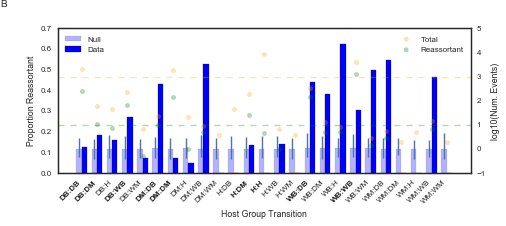

In [55]:
# Plot data vs. null model.
fig = plt.figure(figsize=(7,3))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, 
       color='blue', 
       label='Null', 
       #yerr=np.array(stds)*3, 
       yerr=[np.array(means) - percs[0.5],
             percs[99.5] - np.array(means)],
       alpha=0.3)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Proportion Reassortant')
ax.set_xlabel('Host Group Transition')

for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if log10weights[i] > 3 or log10reassort[i] > 1:
        label.set_weight('bold')

ax2 = ax.twinx()
ax2.scatter(ind+width, log10weights, color='orange', label='Total', alpha=0.3)
ax2.scatter(ind+width, log10reassort, color='green', label='Reassortant', alpha=0.3)
ax2.set_ylabel('log10(Num. Events)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax2.axhline(y=1, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=3, color='orange', alpha=0.3, linestyle='--')

ax.annotate('B', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
# plt.legend()
plt.subplots_adjust(left=0.10, right=0.92, bottom=0.23)
plt.savefig('figures/Proportion Reassortant Ecological.pdf')

In [56]:
!! ls supp_data

['20160210_avian_surveillance.tsv',
 '20160210_mammal_surveillance.tsv',
 '20160214_animal_order.csv',
 '20160214_animal_order.xls',
 '20160214_host_species_graphs.pkl',
 '20160214_host_species_summary_graph-random.pkl',
 'edgelist.csv',
 'host_groups.csv',
 'host_species.csv',
 'hosts_with_classification-NH_EM_mods.csv',
 'patristic_distances.pkl',
 'sequences',
 'trees',
 'viz']

# Compute proportion reassortant over different host COI distances

In [57]:
# Open the host COI data
host_coi = [s for s in SeqIO.parse('supp_data/sequences/host_coi_trimmed.fasta', 'fasta')]
# Modify the SeqRecord ID such that it only contains the host species name.
for s in host_coi:
    s.id = s.id.split('.')[0].replace('_', ' ')
host_coi = SeqIO.to_dict(host_coi)
host_coi

{'American Black Duck': SeqRecord(seq=Seq('ATCCGGGCAGAGCTAGGCCAGCCAGGGACCCTCCTGGGCGACGACCAAATTTAT...TTT', SingleLetterAlphabet()), id='American Black Duck', name='American_Black_Duck.Anas_rubripes', description='American_Black_Duck.Anas_rubripes', dbxrefs=[]),
 'American Green-Winged Teal': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGAACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Green-Winged Teal', name='American_Green-Winged_Teal.Anas_carolinensis', description='American_Green-Winged_Teal.Anas_carolinensis', dbxrefs=[]),
 'American Wigeon': SeqRecord(seq=Seq('ATCCGCGCAGAACTAGGCCAACCAGGGACCCTCCTGGGCGACGACCAAATTTAC...TTT', SingleLetterAlphabet()), id='American Wigeon', name='American_Wigeon.Anas_americana', description='American_Wigeon.Anas_americana', dbxrefs=[]),
 'Baikal Teal': SeqRecord(seq=Seq('ATGGCCCCAAATATCCGCAAATCCCACCCCCTACTAAAAATAATCAACAACTCC...ACC', SingleLetterAlphabet()), id='Baikal Teal', name='Baikal_Teal.Anas_formosa', description='Baikal_T

In [58]:
# Figure out which sequences have gaps. I suspect that the alignment quality might be compromised by those sequences.
ignored = []
for k, sequence in host_coi.items():
    if '-' in str(sequence.seq):
        ignored.append(k)
        print(sequence.seq)
        print(sequence.id)
ignored

ATCCGCGCAGAGCTTGGTCAACCCGGGACTCTCCTGGGCGATGACCAAATTTACAACGTGATCGTCACCGCTCACGCCTTTGTAATAATCTTCTTCATAGTAATACCCATCATAATTGGAGGATTTGGCAACTGATTAGTCCCCCTGATAATCGGTGCCCCAGACATAGCATTCCCACGAATAAATAACATAAGCTTCTGACTCCTTCCATACTCGCCTCATCCACCGTAGAAGCTGCGCTGGTACAGGTTGGACCGTGTACCCACCCCTAGCAGGCAACCTGGCCCACGCCGGAGCCTCAGTAGACCTGGCCATTTTCTCGCTCCACCTAGCCGGTGTTTCCTCCATCCTCGGAGCCATTAACTTCATTACCACAGCCATCAACATAAAACCCCCTGCACTCTCACAGTACCAAACCCCACTTTTCGTCTGATCAGTCCTAATTACCGCCATCCTGCTTCTCCTGTCACTTCCTGTCCTTGCCGCCGGCATCACAATGCTGCTAACCGACCGAAACCTAAACACCACATTCTTCGACCCTGCTGGAGGGGGAGACCCGATCCTGTATCAACACCTA---
Cinnamon Teal
-TCCGGGCCGAACTGGGCCAACCTGGTACACTACTAGGAGATGATCAGATTTACAATGTAATCGTCACTGCCCATGCTTTTGTAATGATCTTTTTTATGGTGATGCCTATTATAATTGGAGGGTTCGGAAACTGATTGGTCCCATTAATAATTGGAGCTCCTGACATAGCATTTCCCCGAATAAACAACATGAGCTTCTGACTCCTCCCTTACTCGCCTCATCTATGGTAGAAGCCGAGCAGGAACTGGCTGAACAGTATACCCACCCCTAGCCGGCAACCTGGCTCATGCAGGAGCATCCGTAGACCTAACTATCTTTTCACTACACCTGGCAGGTGTCTCCTCAATCTTGGGTGCTATTAATTTCATTACTACTATTATTAATATAAAACCTCCTGCCATGTC

['Cinnamon Teal',
 'Domestic Cat',
 'Kelp Gull',
 'Blue-Winged Teal',
 'Baikal Teal',
 'Human',
 'Herring Gull',
 'Chicken',
 'Redhead']

In [59]:
# Impute the COI sequence based on the host species name, ignoring the sequences that have gaps in them. 
for n, d in G.nodes(data=True):    
    try:
        hs = d['host_species']
        assert hs not in ignored
        G.node[n]['coi_sequence'] = host_coi[hs]
    except:
        G.node[n]['coi_sequence'] = None

In [60]:
# Compute proportion under data. 

# Load the patristic distance data.
pds = nx.read_gpickle('supp_data/patristic_distances.pkl')
def proportion_reassortant_coi(G, dist_metric, pds=None):
    """
    Parameters
    - G: the network data, either shuffled or not shuffled.
    - dist_metric: (str) the distance metric.
        - hamming: uses hamming distance between 
    """
    
    assert dist_metric in ['hamming', 'evolutionary']
    
    data = dict()

    if dist_metric == 'hamming':
        bins = np.arange(0,0.3,0.05)  # note: this has been hard-coded
    if dist_metric == 'evolutionary':
        assert isinstance(pds, nx.Graph)
        bins = np.arange(0,1.4,0.1)
        
    for b in bins:
        data[b] = dict()
        data[b]['reassortant'] = 0
        data[b]['clonal'] = 0

    for sc, sk, d in G.edges(data=True):
            
        # Compute the appropriate distance metric.
        if dist_metric == 'hamming':
            sc_coi = G.node[sc]['coi_sequence']
            sk_coi = G.node[sk]['coi_sequence']
            if sc_coi and sk_coi:
                dist = distance(str(sc_coi.seq), str(sk_coi.seq)) / len(str(sc_coi.seq))
                b = bins[int(np.digitize(dist, bins)) - 1] 
                if d['edge_type'] == 'reassortant':
                    data[b]['reassortant'] += d['weight']
                else:
                    data[b]['clonal'] += d['weight']  

        if dist_metric == 'evolutionary':
            sc_host = G.node[sc]['host_species']
            sk_host = G.node[sk]['host_species']
            if pds.has_node(sc_host) and pds.has_node(sk_host):
                dist = pds[sc_host][sk_host]['pd']
                b = bins[int(np.digitize(dist, bins)) - 1]
                if d['edge_type'] == 'reassortant':
                    data[b]['reassortant'] += d['weight']
                else:
                    data[b]['clonal'] += d['weight']  
    return data

coi_data = proportion_reassortant_coi(G, dist_metric='hamming', pds=pds)

In [61]:
coi_data

{0.0: {'clonal': 3009.9999999999986, 'reassortant': 505.95952380952383},
 0.050000000000000003: {'clonal': 360.5, 'reassortant': 203.59523809523802},
 0.10000000000000001: {'clonal': 44.0, 'reassortant': 30.0},
 0.15000000000000002: {'clonal': 83.0, 'reassortant': 88.33333333333333},
 0.20000000000000001: {'clonal': 38.0, 'reassortant': 5.5},
 0.25: {'clonal': 0, 'reassortant': 0}}

In [62]:
# Temporary cell
prop_reassortant = dict()
for k, v in coi_data.items():
    try:
        prop_reassortant[k] = v['reassortant'] / (v['clonal'] + v['reassortant'])
    except:
        prop_reassortant[k] = 0
prop_reassortant

{0.0: 0.14390368273105703,
 0.050000000000000003: 0.36092351848725296,
 0.10000000000000001: 0.40540540540540543,
 0.15000000000000002: 0.5155642023346304,
 0.20000000000000001: 0.12643678160919541,
 0.25: 0}

In [63]:
# Computes proportion under null: shuffle host COIs
def null_proportion_reassortant_coi(G, dist_metric, pds):
    if dist_metric == 'hamming':
        trait = 'coi_sequence'
    if dist_metric == 'evolutionary':
        trait = 'host_species'
    
    host_trait = [d[trait] for n, d in G.nodes(data=True)]
    shuffle(host_trait)

    G_shuffled = G.copy()
    for i, (n, d) in enumerate(G_shuffled.nodes(data=True)):
        G_shuffled.node[n][trait] = host_trait[i]    

    return proportion_reassortant_coi(G_shuffled, dist_metric, pds)    

In [64]:
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_reassortant_coi)(G, dist_metric='hamming', pds=pds) for i in range(500))
end = time()
print(end - start)

1516.4890851974487


In [65]:
# View the results of permutation test simulation
results

[{0.0: {'clonal': 464.2421957671952, 'reassortant': 61.97403381642512},
  0.050000000000000003: {'clonal': 151.08969404186794,
   'reassortant': 13.91111111111111},
  0.10000000000000001: {'clonal': 36.650000000000006,
   'reassortant': 2.388888888888889},
  0.15000000000000002: {'clonal': 172.5094276094276,
   'reassortant': 22.93650793650794},
  0.20000000000000001: {'clonal': 689.4114749984316,
   'reassortant': 92.61742581090408},
  0.25: {'clonal': 0, 'reassortant': 0}},
 {0.0: {'clonal': 449.92518518518455, 'reassortant': 59.64166666666672},
  0.050000000000000003: {'clonal': 131.14285714285714,
   'reassortant': 11.236111111111112},
  0.10000000000000001: {'clonal': 27.944444444444446,
   'reassortant': 5.777777777777778},
  0.15000000000000002: {'clonal': 189.94867724867728,
   'reassortant': 30.33611111111112},
  0.20000000000000001: {'clonal': 705.5253968253966,
   'reassortant': 81.88611111111115},
  0.25: {'clonal': 1.0, 'reassortant': 0}},
 {0.0: {'clonal': 456.34924085576

In [66]:
# Aggregate the results into clonal and reassortant

agg = dict()
agg['clonal'] = defaultdict(list)
agg['reassortant'] = defaultdict(list)

for result in results:
    for dist, d in result.items():
        agg['clonal'][dist].append(d['clonal'])
        agg['reassortant'][dist].append(d['reassortant'])

In [67]:
agg['clonal']

defaultdict(list,
            {0.0: [464.2421957671952,
              449.92518518518455,
              456.34924085576176,
              424.98886013342525,
              479.4033068783064,
              457.63270803270774,
              450.14679664136173,
              439.0018633540373,
              483.82829851307963,
              447.5628019323669,
              419.91907062341824,
              444.2474074074075,
              450.68947089947073,
              440.7384115481937,
              418.2793386243386,
              470.71202208419555,
              455.9220347365997,
              448.81441798941785,
              435.4480676328495,
              429.2691131815043,
              490.06502530480714,
              433.8755820105818,
              458.9534572432394,
              391.00604439843573,
              432.1497354497353,
              510.7915237258712,
              424.277895100069,
              462.1007142857133,
              434.74709611644397,
        

In [68]:
agg['reassortant']

defaultdict(list,
            {0.0: [61.97403381642512,
              59.64166666666672,
              70.09290890269156,
              66.78550724637682,
              63.7777777777778,
              63.74484126984128,
              58.1083333333334,
              65.89806763285024,
              65.1952898550725,
              66.9786231884058,
              51.554278812974474,
              65.77173913043481,
              60.26147342995173,
              54.93466183574882,
              64.36473429951691,
              56.23611111111115,
              62.90833333333333,
              62.446428571428605,
              57.035628019323696,
              73.87028985507246,
              68.26388888888889,
              60.3768115942029,
              68.99563492063493,
              68.28730158730158,
              67.66099033816425,
              53.29987922705316,
              57.506573498964805,
              47.70000000000001,
              56.55555555555556,
              60.8333

In [69]:
# We want to compute the proportion reassortant under the null.
# Iterate over the clonal. 

prop_null = defaultdict(list)

for d, cts in agg['reassortant'].items():
    for i, ct in enumerate(cts):
        try:
            prop_null[d].append(ct / (ct + agg['clonal'][d][i]))
        except:
            prop_null[d].append(np.nan)
prop_null

defaultdict(list,
            {0.0: [0.11777294262752666,
              0.1170438509685607,
              0.13314456096430005,
              0.13580518155554402,
              0.11741531430196761,
              0.12226234396765505,
              0.11432906409862795,
              0.13051708583925642,
              0.11874770271501575,
              0.1301714884718653,
              0.10934717492431617,
              0.12895935295157532,
              0.11793984158115128,
              0.11082841652202696,
              0.13335859261587044,
              0.10672039156891357,
              0.12125029143408571,
              0.12214201222623194,
              0.11581221576034934,
              0.14681873335549972,
              0.12226464930169585,
              0.12215785371083412,
              0.130686151268575,
              0.14867905704303877,
              0.13537322599770893,
              0.09448801904804291,
              0.11936161758428286,
              0.09356597325845833,
 

In [70]:
null_mean = pd.DataFrame(prop_null).mean()
null_mean = null_mean.reset_index()
null_mean.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']
null_mean

null_std = pd.DataFrame(prop_null).std()
null_std = null_std.reset_index()
null_std.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null buttom error range = 0.005
null_b = pd.DataFrame(prop_null).quantile(0.005)
null_b = null_b.reset_index()
null_b.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

# Null top error range = 0.995
null_t = pd.DataFrame(prop_null).quantile(0.995)
null_t = null_t.reset_index()
null_t.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

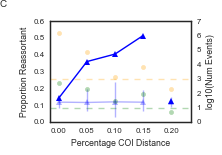

In [71]:
# Plot this data

## 1 November 2015:
## TODO: Rather than plot std*3 or std*5, plot 95% interval from the null. 
## Use the axes.errorbar API: http://matplotlib.org/api/axes_api.html
## [X] DONE



df = pd.DataFrame(coi_data).T
df['prop'] = df['reassortant'] / (df['clonal'] + df['reassortant'])

proportions = df['prop'].dropna().reset_index()
proportions.columns = ['Host COI Hamming Distance', 'Proportion Reassortant']

ixcol = 'Host COI Hamming Distance'
summary = proportions.set_index(ixcol).join(null_mean.set_index(ixcol), rsuffix='r').join(null_std.set_index(ixcol), rsuffix='s')
summary = summary.join(null_b.set_index(ixcol), rsuffix='r').join(null_t.set_index(ixcol), rsuffix='rr')
summary.columns = ['data', 'null', 'std', 'low', 'upp']
summary['low'] = summary['null'] - summary['low']
summary['upp'] = summary['upp'] - summary['null']

fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(111)
d_handle = ax.errorbar(fmt='^', 
                       x=np.array(summary.index), 
                       y=summary['null'], 
                       yerr=[summary['low'], summary['upp']], 
                       color='blue', 
                       alpha=0.3, 
                       label='Null')
summary['null'].iloc[:-1].plot(color='blue', alpha=0.3)

n_handle = ax.errorbar(fmt='^', 
                       x=np.array(summary.index), 
                       y=summary['data'], 
                       color='blue', 
                       label='Data')
summary['data'].iloc[:-1].plot(color='blue')

total_counts = df[['reassortant', 'clonal']].apply(lambda x:np.log10(x)).reset_index()
total_counts.columns = ['Host COI Hamming Distance', 'Reassortant', 'Clonal']
total_counts.replace(-np.inf, np.nan, inplace=True)
total_counts.dropna(inplace=True)
total_counts.set_index('Host COI Hamming Distance', inplace=True)

ax2 = ax.twinx()
# Plot the points version of total
c_xs = np.array(total_counts.index)
c_ys = total_counts['Clonal'] + total_counts['Reassortant']
c_handle = ax2.scatter(x=c_xs, 
                       y=c_ys, 
                       color='orange',
                       alpha=0.3)
# Plot the line
# c_ys.plot(color='olive', alpha=1, linestyle=':')

# Plot the points version
r_xs = np.array(total_counts.index)
r_ys = total_counts['Reassortant']
r_handle = ax2.scatter(x=r_xs, 
                       y=r_ys, 
                       color='green', 
                       alpha=0.3,
                       label='Reassortant')

# Plot the line version
# r_ys.plot(color='red', alpha=1, linestyle=':')

# Set axes parameters
ax.set_xlim(-0.015, 0.235)
ax.set_ylabel('Proportion Reassortant')
ax2.set_ylabel('log10(Num Events)')
ax.set_xlabel('Percentage COI Distance')
ax.annotate('C', xy=(0,1), xycoords='figure fraction', va='top', ha='left')

# Draw the horizontal lines
ax2.axhline(y=1, color='green', linestyle='--', alpha=0.3)
ax2.axhline(y=3, color='orange', linestyle='--', alpha=0.3)

# Final adjustments on the plot
plt.subplots_adjust(left=0.2, right=0.85, bottom=0.2)

# Save figure.
plt.savefig('figures/Proportion Reassortant COI.pdf')

In [72]:
# To get a sense of COIs occur in each bin, let's put together a list of COI distances.
from itertools import product
coi_distances = []
for (k1, s1), (k2, s2) in product(host_coi.items(), host_coi.items()):
    if k1 not in ignored and k2 not in ignored:
        s1 = str(s1.seq)
        s2 = str(s2.seq)
        d = distance(s1, s2) / len(s1)
        coi_distances.append((k1, k2, d))
    

In [73]:
# These are all pairwise host COI distances greater than some number.
coi_distance_df = pd.DataFrame(coi_distances)
coi_distance_df[coi_distance_df[2] >= 0.20]

,0,1,2
4,Mallard,Panda,0.243103
19,Mallard,Camel,0.250000
34,Mallard,Horse,0.215517
57,Mallard,Swine,0.215517
61,Mallard,Ferret,0.218966
62,Mallard,Sloth Bear,0.236207
69,Hooded Merganser,Panda,0.232759
74,Hooded Merganser,Turkey,0.200000
84,Hooded Merganser,Camel,0.241379
99,Hooded Merganser,Horse,0.210345


# Revision: Further analysis of proportion reassortant between specific host species

Reviewer 1 suggested additional analysis of the wild bird category, to see whether, between species, reassortment is over-represented or not.

I have decided to do the analysis by host order instead, in order to keep the "large numbers" necessary.

In [74]:
host_orders = pd.read_csv('supp_data/20160214_animal_order.csv', na_values=['Unknown']).dropna()
host_orders = host_orders[['Order', 'Family', 'Species']]
host_orders['Order'] = host_orders['Order'].str.strip(' ')
host_orders['Family'] = host_orders['Family'].str.strip(' ')
host_orders.head()

,Order,Family,Species
0,Accipitriformes,Accipitridae,Black Kite
1,Accipitriformes,Accipitridae,Golden Eagle
2,Accipitriformes,Accipitridae,Bald Eagle
3,Accipitriformes,Accipitridae,Japanese Sparrowhawk
4,Accipitriformes,Accipitridae,Shikra


In [75]:
# Convert the dataframe to a dictionary, where key = species, and value = order

host_order_map = dict()

for r, d in host_orders.iterrows():
    host_order_map[d['Species']] = d['Family']
    
host_order_map['Mallard']

'Anatidae'

In [76]:
len(set(host_orders['Order'])) ** 2

784

In [77]:
# Impute host order into the graph.

for n, d in G.nodes(data=True):
    if d['host_species'] in host_order_map.keys():
        G.node[n]['host_order'] = host_order_map[d['host_species']]
    else:
        G.node[n]['host_order'] = 'Unknown'

G.nodes(data=True)[0]

('A/Texas/JMS362/2009',
 {'coi_sequence': None,
  'collection_date': Timestamp('2009-11-07 00:00:00'),
  'country': 'USA',
  'host_class': 'Human Human',
  'host_order': 'Unknown',
  'host_species': 'Human',
  'reassortant': False,
  'state': 'Texas',
  'subtype': 'H1N1'})

In [78]:
# Construct the reassortment domain graph based on "host_species"
host_orderG = counts_reassortant_domain_graph(G, 'host_order')
host_orderG.edges(data=True)

[('Podicipedidae',
  'Phasianidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Falconidae',
  'Unknown',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Falconidae',
  'Phasianidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Falconidae',
  'Anatidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Unknown',
  'Podicipedidae',
  {'p_reassortant': 0.25, 'reassortant': 0.5, 'total': 2.0}),
 ('Unknown',
  'Columbidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 3.1428571428571423}),
 ('Unknown',
  'Unknown',
  {'p_reassortant': 0.02214975881707627,
   'reassortant': 245.66666666666652,
   'total': 11091.166666666852}),
 ('Unknown',
  'Anatidae',
  {'p_reassortant': 0.40569820049815997,
   'reassortant': 217.55952380952382,
   'total': 536.2595238095234}),
 ('Unknown',
  'Falconidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'total': 2.0}),
 ('Unknown',
  'Ardeidae',
  {'p_reassortant': 0.0, 'reassortant': 0, 'to

In [79]:
# What edges have sufficient data? 
# They should have at least 10 reassortant events, or 1000 total events.

for u, v, d in host_orderG.edges(data=True):
    if d['reassortant'] < 10 and d['total'] < 1000:
        host_orderG.remove_edge(u, v)

host_orderG.remove_node('Unknown')
host_orderG.edges(data=True)

[('Anatidae',
  'Anatidae',
  {'p_reassortant': 0.28190408474090095,
   'reassortant': 996.857142857142,
   'total': 3536.157142857142}),
 ('Anatidae',
  'Laridae',
  {'p_reassortant': 0.7096774193548387, 'reassortant': 11.0, 'total': 15.5}),
 ('Anatidae',
  'Scolopacidae',
  {'p_reassortant': 0.7050359712230215, 'reassortant': 49.0, 'total': 69.5}),
 ('Anatidae',
  'Phasianidae',
  {'p_reassortant': 0.18968692449355434,
   'reassortant': 51.50000000000001,
   'total': 271.5}),
 ('Phasianidae',
  'Phasianidae',
  {'p_reassortant': 0.056989771066731566,
   'reassortant': 58.499999999999915,
   'total': 1026.4999999999993}),
 ('Phasianidae',
  'Anatidae',
  {'p_reassortant': 0.16910032972209138,
   'reassortant': 29.916666666666664,
   'total': 176.91666666666666}),
 ('Scolopacidae',
  'Anatidae',
  {'p_reassortant': 0.7080536912751679,
   'reassortant': 35.16666666666667,
   'total': 49.666666666666664}),
 ('Scolopacidae',
  'Scolopacidae',
  {'p_reassortant': 0.26609442060085836, 'reas

In [80]:
good_host_orders = set([i[0] for i in host_orderG.edges()])
good_host_orders = good_host_orders.union([i[1] for i in host_orderG.edges()])
good_host_orders

{'Anatidae', 'Laridae', 'Phasianidae', 'Scolopacidae'}

In [81]:
# There are only enough observed data genome transfer between Anseriformes, Galliformes and Charadriiformes.
# Therefore, we will answer the question at this scale, rather than at the generic "mallard and gull".
# A shortcut is to re-label all of the nodes' host groups to "unknown" if they are not in one of the above.

for n, d in G.nodes(data=True):
    if d['host_order'] not in good_host_orders:
        G.node[n]['host_order'] = 'Unknown'


In [82]:
start = time()
null_proportion_domain_graph_reassortant(G, 'host_order', equally=True)
end = time()
print('{0} seconds'.format(end - start))

3.473357915878296 seconds


In [83]:
# This cell takes ~281 seconds to run.
start = time()
results = Parallel(n_jobs=-1)(delayed(null_proportion_domain_graph_reassortant)(G, 'host_order', equally=True) for i in range(100))
end = time()
print(end - start)

372.6175880432129


In [84]:
# # Pickle the graphs to disk, so that we don't have to run the cell above.
# import pickle as pkl

# with open('supp_data/20160214_host_species_graphs.pkl', 'wb') as f:
#     pkl.dump(results, f)

In [85]:
# # Load the pickled data from disk
# with open('supp_data/20160214_host_species_graphs.pkl', 'rb') as f:
#     summary_graphs = pkl.load(f)

In [86]:
# Compute the mean and std. dev.
# Also takes a while, so we have to pickle to disk as well.
# distr_null_p_reassortant is not parallelizable in its current form.
summaryG = distr_null_p_reassortant(results)
for u, v in summaryG.edges():
    if (u, v) not in host_orderG.edges():
        summaryG.remove_edge(u, v)

In [87]:
# nx.write_gpickle(summaryG, 'supp_data/20160214_host_species_summary_graph-random.pkl')

In [88]:
# summaryG = nx.read_gpickle('supp_data/20160214_host_species_summary_graph-random.pkl')

In [89]:
np.percentile(summaryG.edges(data=True)[0][2]['p_reassortant'], [2.5, 97.5])

array([ 0.09547967,  0.14305945])

In [90]:
summaryG.remove_node('Unknown')
summaryG.edges()

[('Scolopacidae', 'Scolopacidae'),
 ('Scolopacidae', 'Anatidae'),
 ('Anatidae', 'Laridae'),
 ('Anatidae', 'Scolopacidae'),
 ('Anatidae', 'Anatidae'),
 ('Anatidae', 'Phasianidae'),
 ('Phasianidae', 'Anatidae'),
 ('Phasianidae', 'Phasianidae')]

In [91]:
# Grab out the "null" model statistics.
means = []  # mean of the distribution under null.
stds  = []  # standard deviation of distribution under null.
names = []  # names
# grab out the 1st, 5th, 95th and 99th percentile of null distribution
percs = dict()
for p in [0.5, 2.5, 97.5, 99.5]:
    percs[p] = []

for sc, sk, d in sorted(summaryG.edges(data=True), key=lambda x:(x[0], x[1])):
    mean = np.mean(d['p_reassortant'])
    std = np.std(d['p_reassortant'])

    names.append('{0}:{1}'.format(sc, sk))
    means.append(mean)
    stds.append(std)
    for p in [0.5, 2.5, 97.5, 99.5]:
        percs[p].append(np.percentile(d['p_reassortant'], p))

In [92]:
percs[0.5]

[0.094169565801784677,
 0.089788536724586476,
 0.095276598574098897,
 0.093382915959294488,
 0.088411253795274813,
 0.090547605260067082,
 0.093201479638582913,
 0.090556075076745096]

In [93]:
summaryG.edges(data=True)

[('Scolopacidae',
  'Scolopacidae',
  {'p_reassortant': [0.11435846824102912,
    0.1232415262421913,
    0.1268704369851642,
    0.11971588597051393,
    0.15070244766877106,
    0.09262071468246498,
    0.12164112417132045,
    0.10099475496251151,
    0.10806800012365768,
    0.11829774694345722,
    0.10235224390037256,
    0.11317198358129596,
    0.13721015095837452,
    0.1313050240815095,
    0.11629656411851738,
    0.12209804989856665,
    0.11662825894670739,
    0.1255838119673029,
    0.11823518556654171,
    0.13232516201317335,
    0.13227345964250894,
    0.12241798529443287,
    0.1151821808250978,
    0.12111917177165141,
    0.10796867184247298,
    0.11657033196017345,
    0.11274359366035981,
    0.13763324438298224,
    0.12150165720401523,
    0.11505864920840012,
    0.12989856491703888,
    0.12150797423891183,
    0.1331496312938018,
    0.1388069328094348,
    0.08853231942361373,
    0.11172127083737111,
    0.11312434054443686,
    0.10298157354314853,
    

In [94]:
# Compile the "data" statistics.
data = []
names_data = []
log10weights = []
log10reassort = []
log10clonal = []
for sc, sk, d in sorted(host_orderG.edges(data=True), key=lambda x:(x[0], x[1])):
    names_data.append('{0}:{1}'.format(sc, sk))
    data.append(d['p_reassortant'])
    log10weights.append(np.log10(d['total']))
    log10reassort.append(np.log10(d['reassortant']))
    log10clonal.append(np.log10(d['total'] - d['reassortant']))
data

[0.28190408474090095,
 0.7096774193548387,
 0.18968692449355434,
 0.7050359712230215,
 0.16910032972209138,
 0.056989771066731566,
 0.7080536912751679,
 0.26609442060085836]

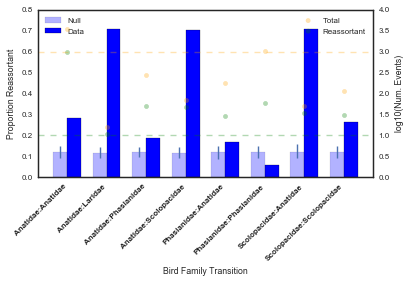

In [97]:
# Plot data vs. null model.
fig = plt.figure(figsize=(6,3))

ind = np.arange(len(means))
width = 0.35

ax = fig.add_subplot(1,1,1)
ax.bar(ind, means, width=width, 
       color='blue', 
       label='Null', 
       #yerr=np.array(stds)*3, 
       yerr=[np.array(means) - percs[0.5],
             percs[99.5] - np.array(means)],
       alpha=0.3)
ax.bar(ind+width, data, width=width, color='blue', label='Data')
ax.set_xticks(ind+width)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylabel('Proportion Reassortant')
ax.set_xlabel('Bird Family Transition')

for i, label in enumerate(ax.get_xaxis().get_ticklabels()):
    if log10weights[i] >= 3 or log10reassort[i] >= 1:
        label.set_weight('bold')

ax2 = ax.twinx()
ax2.scatter(ind+width, log10weights, color='orange', label='Total', alpha=0.3)
ax2.scatter(ind+width, log10reassort, color='green', label='Reassortant', alpha=0.3)
ax2.set_ylabel('log10(Num. Events)')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylim(0,4)

ax2.axhline(y=1, color='green', alpha=0.3, linestyle='--')
ax2.axhline(y=3, color='orange', alpha=0.3, linestyle='--')

# ax.annotate('B', xy=(0,1), xycoords='figure fraction', va='top', ha='left')
# plt.legend()
# plt.subplots_adjust(left=0.10, right=0.92, bottom=0.23)
plt.savefig('figures/Proportion Reassortant Host Family.pdf', bbox_inches='tight')

In [96]:
len(data)

8